______________________________________
# <center>**Trabajo Practico Nº1 para la Materia *Organización de Datos***</center>

*Integrantes*:
- 103963	Carolina Di Matteo	cdimatteo@fi.uba.ar
- 101231	Pablo Salvador Dimartino	pdimartino@fi.uba.ar
- 100113	Juan Sebastian Burgos	jsburgos@fi.uba.ar
- 104415	Valentina Laura Correa	vcorrea@fi.uba.ar

*Grupo*: 14

*Repositorio*: [github](https://github.com/valencorrea/7506R-2C2022-GRUPO14)

*Curso*: Rodriguez

*Cuatrimestre*: 2c2022

Datos provistos por [properati](https://www.properati.com.ar).
______________________________________


# introducción ?

In [54]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
pip install types-all

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
#Importación de librerías

import numpy as np
import cmath as math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import visualkeras as vk

from xgboost import XGBRegressor
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, accuracy_score, f1_score, precision_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from collections import Counter
import unidecode
import re
from joblib import load, dump
import sklearn as sk
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from keras.metrics import RootMeanSquaredError
from keras.metrics import MeanSquaredError

# from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, train_test_split

#Configuración de Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Ejecución con Drive
if 'google.colab' in str(get_ipython()):
    IN_COLAB = True
else:
    IN_COLAB = False

if IN_COLAB :
    from google.colab import drive
    drive.mount('/content/drive')
    properati = pd.read_csv('/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/1d_df_reducido.csv')
    properati_decrip = pd.read_csv('/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP1/properati_argentina_2021_decrip.csv')
    stop_words = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/stopwords.txt'
else:
    properati=pd.read_csv('./1d_df_reducido.csv')
    properati_decrip = pd.read_csv('properati_argentina_2021_decrip.csv')
    stop_words = 'stopwords'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score
def metricas(y_test, y_pred):
    print(f'Accuracy: {round(accuracy_score(y_test, y_pred),2)}')
    print(f'Precision: {round(precision_score(y_test, y_pred, average="macro"),2)}')
    print(f'Recall: {round(recall_score(y_test, y_pred, average="macro"),2)}')
    print(f'F1 Score: {round(f1_score(y_test, y_pred, average="macro"),2)}')

In [59]:
from sklearn import metrics

def performance_y_metricas(regressor, x_train, x_test, y_train, y_test):
  
  y_pred = regressor.predict(x_test)

  pct = np.sum(y_test.values == y_pred) / len(y_test) * 100

  print(f"Se obtuvo un {round(pct,3)}% de aciertos.")

  mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

  print(f"El error según la métrica 'Mean Square Error' de test es: {mse}")

  rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

  print(f"El error según la métrica 'Root Mean Square Error' de test es: {rmse}")

  print(f"El coeficiente de determinación de test es: {regressor.score(x_test, y_test)}")
  
  return y_pred

Hagamos un merge del dataset original y el de descripciones, y quedémonos únicamente con las columnas `id` y `property_description`:

In [60]:
df_decrip = pd.merge(properati, properati_decrip, on="id")
df_decrip = df_decrip[["id", "property_description"]]
df_decrip

,id,property_description
0,1gMQ4rXcpnPs+hhvW11Jdw==,"ESPECTACULAR 4 AMBIENTES, DORMITORIO SUITE, BA..."
1,p7gmyqzdOy/+odHwH5oPyg==,"Excelente departamento, piso alto con una herm..."
2,ZYkS+4dCz1vUENzAREcX9w==,Corredor Responsable: Gustavo Guastello - C.U....
3,UL/s8zoicLDXXwhaelBgFQ==,Corredor Responsable: GRACIELA MENAZZI CMCPDJL...
4,wnz+hkCE7RVBNcqDQEtFSw==,Muy lindo y funcional departamento de un ambie...
...,...,...
74248,CIrzzz0KQkUDDmjnFINLwA==,MONOAMBIENTE DIVIDIDO. FRENTE. 29 M2. IMPECABL...
74249,i5lDg1C7ZEZyETXxCbolhw==,Departamento. Edificio OM Palermo. Living/Come...
74250,b97ekVIR18ZDn3ZsDXWrVQ==,Tres ambientes en Balvanera reciclado a nuevo!...
74251,7oLMN+ZSoOP2N9Uu7Pz68A==,Corredor Responsable: Micaela Perez / Lucas Fe...


## 1. Procesamiento del Lenguaje Natural

### 1.a Ampliación del dataset
___

Busquemos aspectos de una propiedad utilizando la columna `property_description`.

Veamos cuántos registros nulos existen:

In [61]:
print(f"Hay {df_decrip['property_description'].isna().sum()} datos nulos.")

Hay 0 datos nulos.


Veamos cuáles son las 100 palabras más comunes en el campo de descripción de propiedades:

In [62]:
Counter(" ".join(df_decrip["property_description"]).split()).most_common(100)

[('de', 858011),
 ('y', 507798),
 ('con', 401876),
 ('la', 290201),
 ('en', 278181),
 ('a', 243761),
 ('el', 169956),
 ('del', 153280),
 ('que', 140058),
 ('por', 133636),
 ('al', 125215),
 ('-', 113886),
 ('un', 103720),
 ('las', 90713),
 ('los', 88438),
 ('para', 88196),
 ('se', 63111),
 ('DE', 56458),
 ('son', 56422),
 ('2', 52793),
 ('es', 50385),
 ('una', 48933),
 ('3', 41260),
 ('cocina', 38889),
 ('ambientes', 38850),
 ('valor', 38421),
 ('esta', 38294),
 ('muy', 36893),
 ('x', 36800),
 ('Av.', 36631),
 ('comedor', 35535),
 ('baño', 35477),
 ('Y', 34142),
 ('CON', 33915),
 ('no', 33913),
 ('piso', 33349),
 ('o', 33053),
 ('/', 32255),
 ('tu', 32102),
 ('A', 32063),
 ('hasta', 30270),
 ('balcón', 29805),
 ('inmueble', 28725),
 ('casa', 28656),
 ('No', 28636),
 ('propiedad.', 28071),
 ('30%', 27685),
 ('departamento', 27671),
 ('EN', 27267),
 ('cuadras', 27071),
 ('Corredor', 26992),
 ('préstamo', 26921),
 ('cuota', 26781),
 ('medidas', 26423),
 ('Responsable:', 25971),
 ('living'

Podemos observar que podríamos optimizar el texto mediante algunas técnicas de reducción y/o transformación. Entre otras:

Eliminemos la etiqueta `<br>` de html:

In [63]:
df_decrip["property_description"] = df_decrip["property_description"].apply(lambda line: line.replace("<br>", " "))

Transformemos todas las palabras a minúsculas, de modo que el contador no realice distinciones:

In [64]:
df_decrip["property_description"] = df_decrip["property_description"].apply(lambda line: line.lower())

Quitemos los tildes de las letras:

In [65]:
df_decrip["property_description"] = df_decrip["property_description"].apply(lambda line: unidecode.unidecode(line))

Eliminemos los símbolos:

In [66]:
df_decrip["property_description"] = df_decrip["property_description"].apply(lambda line: re.sub(r'[^\w]', ' ', line))

Eliminemos los espacios múltiples entre palabras:

In [67]:
df_decrip["property_description"] = df_decrip["property_description"].apply(lambda line: re.sub("\s\s+" , " ", line))

Utilizando el contenido del archivo `stop_words.txt`, eliminemos palabras sin significado del datset y colocamos los cambios en uno nuevo:

In [68]:
df_nostopwords = df_decrip.copy()

In [69]:
with open(stop_words) as f:
    lines = f.read().splitlines()

f = lambda x: ' '.join([item for item in x.split() if item not in lines])

df_nostopwords["property_description"] = df_nostopwords["property_description"].apply(f)

Luego de estas transformaciones, veamos cuáles son las palabras más utilizadas:

In [70]:
Counter(" ".join(df_nostopwords["property_description"]).split()).most_common(100)

[('cocina', 89459),
 ('2', 88138),
 ('bano', 74430),
 ('3', 74276),
 ('ambientes', 71519),
 ('balcon', 71288),
 ('comedor', 68491),
 ('piso', 67831),
 ('living', 63836),
 ('propiedad', 62563),
 ('departamento', 54477),
 ('edificio', 53420),
 ('av', 50589),
 ('1', 50145),
 ('dormitorio', 48863),
 ('completo', 48392),
 ('pisos', 46212),
 ('4', 45875),
 ('frente', 44714),
 ('expensas', 44286),
 ('n', 44025),
 ('excelente', 41315),
 ('corredor', 41146),
 ('medidas', 41048),
 ('x', 40904),
 ('inmueble', 40569),
 ('responsable', 37724),
 ('amplio', 36355),
 ('m2', 34044),
 ('30', 34028),
 ('placard', 33950),
 ('casa', 32678),
 ('dormitorios', 32258),
 ('lavadero', 31875),
 ('c', 31791),
 ('cuadras', 31167),
 ('luminoso', 30549),
 ('cucicba', 30414),
 ('accede', 29383),
 ('terraza', 29330),
 ('ley', 27849),
 ('aire', 27700),
 ('lendar', 27450),
 ('queres', 27417),
 ('prestamo', 27367),
 ('vista', 26980),
 ('venta', 26865),
 ('cuota', 26857),
 ('podes', 26581),
 ('salida', 26111),
 ('ubicacion

Seleccionemos los aspectos que nos parecen relevantes, para luego buscar sus posibles valores.

Para esto, elegimos: `cocina`, `pisos`, `calefaccion`, `expensas`, `lavadero`, `balcon`, `cochera` y `aire` y limpiamos cualquier tipo de formato restante en el dataset:

In [71]:
aspectos = ['cocina', 'pisos', 'calefaccion', 'expensas', 'lavadero', 'balcon', 'cochera', 'aire']

In [72]:
def f(line, word):
    format = r"\W*([\w]+)"
    n = 2
    x = re.search(r'{}\W*{}{}'.format(format*n, word, format*n), line)
    if x is not None:
        return x.group()
    else:
        return ""

for word in aspectos:
    df_nostopwords[word] = df_nostopwords["property_description"].apply(lambda line: f(line, word))

Veamos cuáles son las 15 palabras más comunes para cada uno de los aspectos elegidos:

In [73]:
cant_val_aspectos = 15

#### Aspecto `cocina`




In [74]:
Counter(" ".join(df_nostopwords["cocina"]).split()).most_common(cant_val_aspectos)

[('cocina', 62809),
 ('comedor', 19199),
 ('integrada', 11530),
 ('living', 9979),
 ('bano', 8949),
 ('lavadero', 6978),
 ('balcon', 6225),
 ('independiente', 6077),
 ('completo', 5385),
 ('diario', 4993),
 ('muebles', 4829),
 ('separada', 4746),
 ('amplia', 4518),
 ('toilette', 3963),
 ('completa', 3692)]

Para `cocina`, los valores podrían ser: 
- integrada
- lavadero
- completa

#### Aspecto `pisos`

In [75]:
Counter(" ".join(df_nostopwords["pisos"]).split()).most_common(cant_val_aspectos)

[('pisos', 31829),
 ('parquet', 6394),
 ('madera', 4427),
 ('porcelanato', 4025),
 ('living', 3671),
 ('edificio', 3621),
 ('comedor', 3155),
 ('unidades', 1821),
 ('cocina', 1754),
 ('departamentos', 1662),
 ('bano', 1576),
 ('2', 1411),
 ('4', 1313),
 ('3', 1241),
 ('ambientes', 1201)]

Para `pisos`, los valores podrían ser: 
- porcelanato
- parquet
- ceramicos

#### Aspecto `calefaccion`

In [76]:
Counter(" ".join(df_nostopwords["calefaccion"]).split()).most_common(cant_val_aspectos)

[('calefaccion', 15447),
 ('radiante', 4448),
 ('losa', 3916),
 ('central', 3444),
 ('caliente', 2653),
 ('agua', 2257),
 ('radiadores', 2052),
 ('individual', 1921),
 ('aire', 1777),
 ('piso', 1527),
 ('caldera', 1246),
 ('tiro', 1197),
 ('acondicionado', 1097),
 ('servicios', 1056),
 ('ambientes', 798)]

Para `calefaccion`, los valores podrían ser: 
- radiadores
- radiante
- central
- individual

#### Aspecto `expensas`

In [77]:
Counter(" ".join(df_nostopwords["expensas"]).split()).most_common(cant_val_aspectos*2)

[('expensas', 35164),
 ('servicios', 6846),
 ('impuestos', 5906),
 ('valores', 5559),
 ('bajas', 4879),
 ('funcionales', 4365),
 ('000', 3296),
 ('abl', 2445),
 ('medidas', 1959),
 ('aysa', 1606),
 ('sujetos', 1542),
 ('propiedad', 1276),
 ('superficies', 1260),
 ('indicados', 1242),
 ('consignadas', 1189),
 ('2021', 1147),
 ('tasas', 1143),
 ('mensuales', 1138),
 ('consignado', 1084),
 ('gastos', 1053),
 ('presente', 1046),
 ('ambientes', 1044),
 ('sujeto', 947),
 ('500', 942),
 ('edificio', 915),
 ('aprox', 867),
 ('4', 835),
 ('incluyen', 829),
 ('2', 819),
 ('3', 806)]

Para `expensas`, los valores podrían ser: 
- serviocios
- impuestos 
- bajas

#### Aspecto `lavadero`

In [78]:
Counter(" ".join(df_nostopwords["lavadero"]).split()).most_common(cant_val_aspectos)

[('lavadero', 28548),
 ('independiente', 7972),
 ('cocina', 7923),
 ('comedor', 4376),
 ('bano', 4342),
 ('diario', 3175),
 ('servicio', 2922),
 ('dependencia', 2920),
 ('incorporado', 2506),
 ('completo', 2102),
 ('patio', 1882),
 ('separado', 1807),
 ('balcon', 1738),
 ('espacio', 1736),
 ('toilette', 1385)]

Para `lavadero`, los valores podrían ser: 
- independiente
- cocina
- comedor

#### Aspecto `balcon`

In [79]:
Counter(" ".join(df_nostopwords["balcon"]).split()).most_common(cant_val_aspectos)

[('balcon', 42917),
 ('salida', 9996),
 ('frente', 9711),
 ('comedor', 8052),
 ('ambientes', 6387),
 ('corrido', 6126),
 ('cocina', 4569),
 ('living', 4207),
 ('vista', 4051),
 ('amplio', 3716),
 ('terraza', 3682),
 ('aterrazado', 3172),
 ('2', 3151),
 ('luminoso', 2855),
 ('3', 2684)]

Para `balcon`, los valores podrían ser: 
- frente
- amplio 
- terraza 
- salida 
- corrido
- luminoso

#### Aspecto `cochera`

In [80]:
Counter(" ".join(df_nostopwords["cochera"]).split()).most_common(cant_val_aspectos*2)

[('cochera', 17208),
 ('cocheras', 7359),
 ('fija', 4756),
 ('cubierta', 4118),
 ('ambientes', 3484),
 ('baulera', 2863),
 ('2', 2467),
 ('edificio', 2119),
 ('balcon', 1521),
 ('3', 1399),
 ('opcional', 1307),
 ('1', 1132),
 ('fijas', 1080),
 ('terraza', 1007),
 ('dependencia', 979),
 ('posibilidad', 958),
 ('piso', 826),
 ('frente', 780),
 ('bano', 760),
 ('departamento', 759),
 ('disponibles', 759),
 ('4', 753),
 ('servicio', 729),
 ('planta', 701),
 ('parrilla', 699),
 ('espacio', 615),
 ('subsuelo', 598),
 ('amenities', 586),
 ('completo', 553),
 ('patio', 525)]

Para `cochera`, los valores podrían ser: 
- fija
- cubierta

#### Aspecto `aire`

In [81]:
Counter(" ".join(df_nostopwords["aire"]).split()).most_common(cant_val_aspectos)

[('aire', 20578),
 ('acondicionado', 14337),
 ('frio', 5985),
 ('aires', 5809),
 ('split', 2204),
 ('ciudad', 2020),
 ('acondicionados', 1961),
 ('luz', 1851),
 ('equipos', 1585),
 ('calefaccion', 1493),
 ('instalacion', 1413),
 ('ambientes', 1411),
 ('living', 1138),
 ('central', 1062),
 ('balcon', 1002)]

Para `aire`, posibles valores son: 
- split 
- central 
- acondicionado

#### Consolidación de valores

A continuación creamos la variable `values`, que contiene los posibles valores para cada uno de los aspectos elegidos:

In [82]:
values_cocina = ['integrada' , 'lavadero' , 'completa']
values_pisos = ['porcelanato' , 'parquet' , 'ceramicos']
values_calefaccion = ['radiadores' , 'radiante' , 'central' , 'individual']
values_expensas = ['serviocios' , 'impuestos' , 'bajas']
values_lavadero = ['independiente' , 'cocina' , 'comedor']
values_balcon = ['frente' , 'amplio' , 'terraza' , 'salida' , 'corrido' , 'luminoso']
values_cochera = ['fija' , 'cubierta']
values_aire = ['split' , 'central' , 'acondicionado']

In [83]:
values = [values_cocina, values_pisos, values_calefaccion, values_expensas, values_lavadero, values_balcon, values_cochera, values_aire]

En primer lugar, creamos un dataset auxiliar que tenga los IDs y las columnas de los aspectos:

In [84]:
aux_df = df_nostopwords.copy()
aux_df.drop('property_description', inplace=True, axis=1)

Luego creamos una función a la que -pasándole un dataset, los aspectos y el listado de valores posibles- reemplace el contenido de las columnas por los valores correspondientes:

In [85]:
def limpiar_values_de_aspects(df, aspects, values):
    i = 0
    for aspect in aspects:
        for word in values[i]:
            df[aspect] = df[aspect].apply(lambda line: word if word in line else line)
        df[aspect] = df[aspect].apply(lambda line: line if len(line.split())<2 else '')
        i = i+1

Modificamos las columnas de los aspectos, para que sólo queden los valores correspondientes:

In [86]:
limpiar_values_de_aspects(aux_df, aspectos, values)
aux_df.head(20)

,id,cocina,pisos,calefaccion,expensas,lavadero,balcon,cochera,aire
0,1gMQ4rXcpnPs+hhvW11Jdw==,,,,impuestos,,terraza,,
1,p7gmyqzdOy/+odHwH5oPyg==,,,,,,amplio,,
2,ZYkS+4dCz1vUENzAREcX9w==,,,,,,,,
3,UL/s8zoicLDXXwhaelBgFQ==,,,,,,,,acondicionado
4,wnz+hkCE7RVBNcqDQEtFSw==,,,,,,,,
5,+QvrIZqpMPRxlz+ilj1LkA==,integrada,,,,independiente,,,
6,MGM2azMohIovCwT8jcExeQ==,,,,,,,,
7,uLDfFrhFSDasD1UObhqHmg==,lavadero,,,,independiente,frente,,acondicionado
8,6iHL1ay2QcrLeLh+K33ziw==,,,,bajas,,,,
9,8J08zxRGfHVQ3dzTyopnWQ==,,,radiante,,,salida,,


Por último hacemos el merge con el dataset original, teniendo en cuenta los IDs:

In [87]:
df = properati.copy()
df = pd.merge(df,aux_df, on="id")
df.head(20)

,id,start_date,end_date,latitud,longitud,place_l4,property_type,property_rooms,property_surface_total,property_price,cocina,pisos,calefaccion,expensas,lavadero,balcon,cochera,aire
0,1gMQ4rXcpnPs+hhvW11Jdw==,738005,738091,-34.622385,-58.448886,Caballito,Departamento,4.0,113.0,288000.0,,,,impuestos,,terraza,,
1,p7gmyqzdOy/+odHwH5oPyg==,737817,737946,-34.618084,-58.359912,Puerto Madero,Departamento,2.0,70.0,450000.0,,,,,,amplio,,
2,ZYkS+4dCz1vUENzAREcX9w==,738035,738035,-34.601159,-58.398106,Balvanera,Departamento,1.0,33.0,77243.0,,,,,,,,
3,UL/s8zoicLDXXwhaelBgFQ==,738140,738195,-34.605542,-58.390007,San Nicolás,Departamento,1.0,30.0,65000.0,,,,,,,,acondicionado
4,wnz+hkCE7RVBNcqDQEtFSw==,737868,737946,-34.593266,-58.381426,Retiro,Departamento,1.0,40.0,79000.0,,,,,,,,
5,+QvrIZqpMPRxlz+ilj1LkA==,737881,737965,-34.564779,-58.505463,Villa Urquiza,PH,6.0,184.0,350000.0,integrada,,,,independiente,,,
6,MGM2azMohIovCwT8jcExeQ==,737879,737907,-34.612009,-58.475824,Villa del Parque,Casa,5.0,320.0,450000.0,,,,,,,,
7,uLDfFrhFSDasD1UObhqHmg==,737833,738127,-34.583237,-58.444843,Colegiales,Departamento,2.0,63.0,199000.0,lavadero,,,,independiente,frente,,acondicionado
8,6iHL1ay2QcrLeLh+K33ziw==,737829,737867,-34.595346,-58.445428,Villa Crespo,Departamento,3.0,72.0,145000.0,,,,bajas,,,,
9,8J08zxRGfHVQ3dzTyopnWQ==,738099,738206,-34.599183,-58.425177,Almagro,Departamento,3.0,65.0,190000.0,,,radiante,,,salida,,


#### Exportación de Datos

Exportamos los datasets generados:

In [88]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/DATASETS/1a_df_nostopwords.csv'
else:
  path = 'DATASETS/1a_df_nostopwords.csv'

df_nostopwords.to_csv(path)

In [89]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/DATASETS/1a_df_ampliado.csv'
else:
  path = 'DATASETS/1a_df_ampliado.csv'

df.to_csv(path)

### 1.b Modelos
___

#### Sin optimización de hiperparámetros

Entrenemos un modelo de XGBoost con los mismos hiperparámetros utilizados en el TP1.

En esta línea, cargamos en memoria el modelo efectivamente utilizado:

In [90]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP1/MODELOS/XGB_Regressor_Train.joblib'
else:
  path = './MODELOS/XGB_Regressor_Train.joblib'

XGB_Regressor_TP1 = load(path)

[19:23:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Realizamos One Hot Encoding para las variables cualitativas:

In [91]:
df_dummies = pd.get_dummies(df, columns=['place_l4', 'property_type', 'cocina', 'pisos', 'lavadero', 'calefaccion', 'expensas', 'balcon', 'cochera', 'aire'], drop_first=True)
df_dummies.head(5)

,id,start_date,end_date,latitud,longitud,property_rooms,property_surface_total,property_price,place_l4_Agronomía,place_l4_Almagro,...,balcon_corrido,balcon_frente,balcon_luminoso,balcon_salida,balcon_terraza,cochera_cubierta,cochera_fija,aire_acondicionado,aire_central,aire_split
0,1gMQ4rXcpnPs+hhvW11Jdw==,738005,738091,-34.622385,-58.448886,4.0,113.0,288000.0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,p7gmyqzdOy/+odHwH5oPyg==,737817,737946,-34.618084,-58.359912,2.0,70.0,450000.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ZYkS+4dCz1vUENzAREcX9w==,738035,738035,-34.601159,-58.398106,1.0,33.0,77243.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,UL/s8zoicLDXXwhaelBgFQ==,738140,738195,-34.605542,-58.390007,1.0,30.0,65000.0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,wnz+hkCE7RVBNcqDQEtFSw==,737868,737946,-34.593266,-58.381426,1.0,40.0,79000.0,0,0,...,0,0,0,0,0,0,0,0,0,0


Separamos el dataset en train y test con una proporción 80% para train y 20% para test:

In [92]:
train = df_dummies.sample(frac=0.8, random_state=200)

y_train = train["property_price"]

train.drop(["property_price", "id"], inplace=True, axis=1)

In [93]:
test = df_dummies.drop(train.index)

y_test = test["property_price"]

test.drop(["property_price", "id"], inplace=True, axis=1)

Entrenamos el modelo:

In [94]:
XGB_Regressor_TP1.fit(train, y_train)

[19:23:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.3, gamma=0.1, learning_rate=0.3, max_depth=6,
             min_child_weight=5, missing=nan)

Hagamos las predicciones y veamos cómo resultaron las métricas del modelo:

In [95]:
y_pred = performance_y_metricas(XGB_Regressor_TP1, train, test, y_train, y_test)

Se obtuvo un 0.0% de aciertos.
El error según la métrica 'Mean Square Error' de test es: 7490858591.217763
El error según la métrica 'Root Mean Square Error' de test es: 86549.74633826353
El coeficiente de determinación de test es: 0.8779061886253998


#### Con optimización de hiperparámetros

Veamos cómo se comporta el score con la optimización de hiperparámetros:

In [96]:
params_grid = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
               'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
               'min_child_weight': [1, 3, 5, 7],
               'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
               'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]}

randomCV = RandomizedSearchCV(estimator = XGBRegressor(),
                              param_distributions = params_grid,
                              scoring = make_scorer(accuracy_score),
                              cv = StratifiedKFold(n_splits = 5),
                              n_iter = 5)

randomCV.fit(train, y_train)

[19:23:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:23:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:24:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBRegressor(), n_iter=5,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring=make_scorer(accuracy_score))

In [97]:
y_pred = performance_y_metricas(randomCV.best_estimator_, train, test, y_train, y_test)

Se obtuvo un 0.0% de aciertos.
El error según la métrica 'Mean Square Error' de test es: 8129319875.796772
El error según la métrica 'Root Mean Square Error' de test es: 90162.74106190856
El coeficiente de determinación de test es: 0.8674998819650706


Observamos que el score disminuyó levemente.

#### Métricas previas

Veamos que las métricas obtenidas en el TP1 fueron, para dataset de train:

Se obtuvo un 0.0% de aciertos.

El error según la métrica 'Mean Square Error' de test es: 70586895109.33229

El error según la métrica 'Root Mean Square Error' de test es: 265681.9435139172

El coeficiente de determinación de test es: 0.44112156174433736

Y, para el dataset reducido:

Se obtuvo un 0.0% de aciertos.

El error según la métrica 'Mean Square Error' de test es: 78861262549.04588

El error según la métrica 'Root Mean Square Error' de test es: 280822.4751494187

El coeficiente de determinación de test es: 0.3756084725923362

Y podemos concluir que las métricas en comparación mejoraron un 43% aproximadamente.

#### Exportación de Datos

Finalmente, exportamos el modelo utilizado para predecir, resultante de la optimización de hiperparámetros:

In [98]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/MODELOS/XGB_Regressor.joblib'
else:
  path = './MODELOS/XGB_Regressor.joblib'

dump(randomCV.best_estimator_, path)

['/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP2/MODELOS/XGB_Regressor.joblib']

## 2. Redes Neuronales

Trabajemos con el dataset reducido del primer TP y entrenemos dos modelos de redes neuronales para regresión y clasificación:

In [125]:
if IN_COLAB:
  path = '/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP1/DATASETS/1d_df_reducido.csv'
else:
  path = 'DATASETS/1d_df_reducido.csv'

df_trabajo_tp1 = pd.read_csv(path)

### 2.a Regresión

Tomamos el dataset reducido del TP1 como punto de partida, luego aplicamos One Hot Encoding y separamos en train y test.
Adicionalmente dropeamos la columna `property_price` en ambos datasets.

In [129]:
df_trabajo_tp1_regressor = df_trabajo_tp1.copy()

In [130]:
df_trabajo_tp1_regressor = pd.get_dummies(df_trabajo_tp1_regressor, columns=['place_l4', 'property_type'], drop_first=False)

In [131]:
train_tp1_regressor = df_trabajo_tp1_regressor.sample(frac=0.8, random_state=200)
y_train_tp1_regressor = train_tp1_regressor["property_price"]
train_tp1_regressor.drop(["property_price"], inplace=True, axis=1)

test_tp1_regressor = df_trabajo_tp1_regressor.drop(train_tp1_regressor.index)
y_test_tp1_regressor = test_tp1_regressor["property_price"]
test_tp1_regressor.drop(["property_price"], inplace=True, axis=1)

Normalizamos las entradas con StandardScaler

In [132]:
sscaler = StandardScaler()

train_tp1_regressor['start_date'] = sscaler.fit_transform(pd.DataFrame(train_tp1_regressor['start_date']))
test_tp1_regressor['start_date'] = sscaler.transform(pd.DataFrame(test_tp1_regressor['start_date']))

train_tp1_regressor['end_date'] = sscaler.fit_transform(pd.DataFrame(train_tp1_regressor['end_date']))
test_tp1_regressor['end_date'] = sscaler.transform(pd.DataFrame(test_tp1_regressor['end_date']))

train_tp1_regressor['latitud'] = sscaler.fit_transform(pd.DataFrame(train_tp1_regressor['latitud']))
test_tp1_regressor['latitud'] = sscaler.transform(pd.DataFrame(test_tp1_regressor['latitud']))

train_tp1_regressor['longitud'] = sscaler.fit_transform(pd.DataFrame(train_tp1_regressor['longitud']))
test_tp1_regressor['longitud'] = sscaler.transform(pd.DataFrame(test_tp1_regressor['longitud']))

train_tp1_regressor['property_rooms'] = sscaler.fit_transform(pd.DataFrame(train_tp1_regressor['property_rooms']))
test_tp1_regressor['property_rooms'] = sscaler.transform(pd.DataFrame(test_tp1_regressor['property_rooms']))

train_tp1_regressor['property_surface_total'] = sscaler.fit_transform(pd.DataFrame(train_tp1_regressor['property_surface_total']))
test_tp1_regressor['property_surface_total'] = sscaler.transform(pd.DataFrame(test_tp1_regressor['property_surface_total']))

train_tp1_regressor.head(5)

,Unnamed: 0,start_date,end_date,latitud,longitud,property_rooms,property_surface_total,place_l4_Abasto,place_l4_Agronomía,place_l4_Almagro,...,place_l4_Villa Pueyrredón,place_l4_Villa Real,place_l4_Villa Riachuelo,place_l4_Villa Santa Rita,place_l4_Villa Soldati,place_l4_Villa Urquiza,place_l4_Villa del Parque,property_type_Casa,property_type_Departamento,property_type_PH
13016,81870,-1.075966,-0.800753,1.230341,-0.062246,0.982462,0.658283,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10977,353128,-0.062060,-0.153878,-0.274093,1.981748,-0.609524,-0.350912,0,0,0,...,0,0,0,0,0,0,0,0,1,0
43850,221599,-0.013779,0.156358,-0.143889,-1.977069,0.982462,0.566538,0,0,0,...,0,0,0,0,0,0,0,0,1,0
69244,121520,0.826315,0.294974,1.168270,-0.625927,0.186469,0.016068,0,0,0,...,0,0,0,0,0,0,0,0,1,0
58282,300742,0.382127,0.842837,-2.261216,-1.573182,-0.609524,-0.564984,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Creamos el modelo con 2 capas ocultas, entrada de igual cantidad de columnas que el dataset, y salida de 1 parámetro.
Luego lo compilamos utilizando RMSprop como optimizador, lo entrenamos con el dataset de train, y predecimos con el de test.

In [133]:
d_in = train_tp1_regressor.shape[1]

modelo = keras.Sequential([
    keras.layers.Dense(d_in, input_shape=(d_in,), activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1)
])

modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 72)                5256      
                                                                 
 dense_7 (Dense)             (None, 30)                2190      
                                                                 
 dense_8 (Dense)             (None, 1)                 31        
                                                                 
Total params: 7,477
Trainable params: 7,477
Non-trainable params: 0
_________________________________________________________________


In [134]:
modelo.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

cant_epochs = 100
historia = modelo.fit(train_tp1_regressor, 
                      y_train_tp1_regressor, 
                      epochs=cant_epochs, 
                      verbose=False, 
                      use_multiprocessing=True, 
                      workers=4)
y_pred_tp1 = modelo.predict(test_tp1_regressor)

465/465 [==============================] - 1s 1ms/step


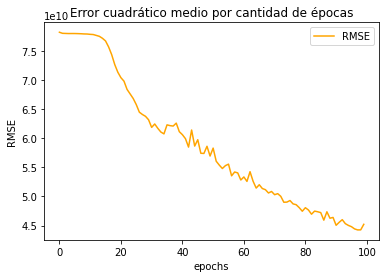

In [135]:
epochs = range(cant_epochs)
plt.plot(epochs, historia.history['loss'], color='orange', label='RMSE')
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.title('Error cuadrático medio por cantidad de épocas')
plt.legend()

In [136]:
res = modelo.evaluate(test_tp1_regressor, y_test_tp1_regressor)
error = np.absolute(np.diagonal(np.subtract(y_test_tp1_regressor.values, y_pred_tp1)))
error_porcentual = error / y_test_tp1_regressor.values
print('El error relativo porcentual promedio es:', round(np.mean(error_porcentual),2), 'y su mediana es:', round(np.median(error_porcentual),2))
print('El error RMS es:', round(res[1],2))

465/465 [==============================] - 1s 2ms/step - loss: 486690160640.0000 - root_mean_squared_error: 697631.8125
El error relativo porcentual promedio es: 4.32 y su mediana es: 3.24
El error RMS es: 697631.81


### 2.b Clasificación

Nuevamente tomamos el dataset generado del TP1 y aplicamos aplicamos One Hot Encoding y separamos en train y test.
Adicionalmente normalizamos mediante Z-Score:

In [144]:
df_trabajo_tp1_classifier = df_trabajo_tp1.copy()

In [145]:
df_trabajo_tp1_classifier["property_m2price"] = df_trabajo_tp1_classifier["property_price"] / df_trabajo_tp1_classifier["property_surface_total"]
df_trabajo_tp1_classifier.sort_values(by=["property_m2price"], inplace=True)

In [146]:
df_trabajo_tp1_classifier['tipo_precio_3'] = pd.qcut(x=df_trabajo_tp1_classifier.loc[df_trabajo_tp1_classifier['property_type'] == 'Departamento']['property_m2price'], q=4, labels=['bajo', 'medio', 'medio2', 'alto']).replace("medio2","medio")
df_trabajo_tp1_classifier['tipo_precio_3'].fillna(pd.qcut(x=df_trabajo_tp1_classifier.loc[df_trabajo_tp1_classifier['property_type'] == 'Casa']['property_m2price'], q=4, labels=['bajo', 'medio', 'medio2', 'alto']).replace("medio2","medio"), inplace=True)
df_trabajo_tp1_classifier['tipo_precio_3'].fillna(pd.qcut(x=df_trabajo_tp1_classifier.loc[df_trabajo_tp1_classifier['property_type'] == 'PH']['property_m2price'], q=4, labels=['bajo', 'medio', 'medio2', 'alto']).replace("medio2","medio"), inplace=True)

In [147]:
train_tp1_regressor = df_trabajo_tp1_regressor.sample(frac=0.8, random_state=200)
y_train_tp1_regressor = train_tp1_regressor["property_price"]
train_tp1_regressor.drop(["property_price"], inplace=True, axis=1)

test_tp1_regressor = df_trabajo_tp1_regressor.drop(train_tp1_regressor.index)
y_test_tp1_regressor = test_tp1_regressor["property_price"]
test_tp1_regressor.drop(["property_price"], inplace=True, axis=1)

In [143]:
df_trabajo_tp1_classifier = pd.get_dummies(df_trabajo_tp1_classifier, columns=['place_l4', 'property_type'], drop_first=False)

train_tp1_classifier = df_trabajo_tp1_classifier.sample(frac=0.8, random_state=200)
y_train_tp1_classifier = train_tp1_classifier["tipo_precio_3"]
train_tp1_classifier.drop(["property_price", "id", "tipo_precio_3", "property_m2price"], inplace=True, axis=1)

train_tp1_classifier[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(train_tp1_classifier[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

test_tp1_classifier = df_trabajo_tp1_classifier.drop(train_tp1_classifier.index)
y_test_tp1_classifier = test_tp1_classifier["tipo_precio_3"]
test_tp1_classifier.drop(["property_price", "id", "tipo_precio_3", "property_m2price"], inplace=True, axis=1)

test_tp1_classifier[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']] = zscore(test_tp1_classifier[['start_date', 'end_date', 'latitud', 'longitud', 'property_rooms', 'property_surface_total']], axis=1)

KeyError: ignored

Modelamos con 1 capa oculta de 50 unidades, que recibe como entrada las columnas del dataset. La salida tiene 3 unidades.

In [ ]:
d_in=train.shape[1]
modelo = keras.Sequential([
    keras.layers.Dense(50, input_shape=(d_in,)),
    keras.layers.Dense(3, activation='softmax')
])

modelo.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 50)                3600      
                                                                 
 dense_13 (Dense)            (None, 3)                 153       
                                                                 
Total params: 3,753
Trainable params: 3,753
Non-trainable params: 0
_________________________________________________________________


Aplicamos one hot encoding a y_train, para que tenga 3 columnas al igual que la salida del modelo.

In [ ]:
y_train = pd.get_dummies(y_train, columns=['tipo_precio_3'], drop_first=False)
y_train

,bajo,medio,alto
52856,0,1,0
46654,0,1,0
37932,1,0,0
9614,0,0,1
630,0,0,1
...,...,...,...
36468,0,1,0
46494,1,0,0
9659,0,1,0
56568,0,1,0


Compilamos el modelo con optimizador Adam y loss de crossentropy categórico. Luego entrenamos con los datos de train y predecimos con test.

In [ ]:
modelo.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['AUC', 'Accuracy', 'Recall', 'Precision'],
)

cant_epochs=100
historia = modelo.fit(train, y_train, epochs=cant_epochs, verbose=False, use_multiprocessing=True, workers=4)

In [ ]:
y_pred = modelo.predict(test)

465/465 [==============================] - 0s 516us/step


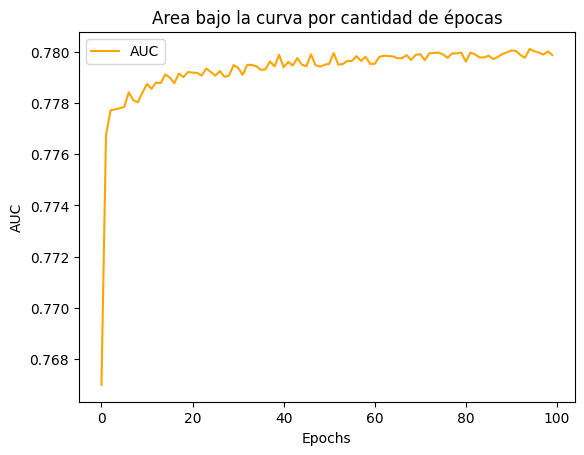

In [ ]:
epochs = range(cant_epochs)

plt.plot(epochs, historia.history['auc'], color='orange', label='AUC')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title('Area bajo la curva por cantidad de épocas')
plt.legend()

Reorganizamos los valores predichos para que queden en una sola columna, y comparamos con y_test

In [ ]:
def myfunction(x):
    mx = max(x[0], x[1], x[2])
    if mx == x[0]:
        return "bajo"
    elif mx == x[1]:
        return "medio"
    elif mx == x[2]:
        return "alto"

y_pred_txt = np.apply_along_axis(myfunction, axis=1, arr=y_pred)
metricas(y_test, y_pred_txt)

Accuracy: 0.57
Precision: 0.63
Recall: 0.49
F1 Score: 0.48


array(['medio', 'medio', 'alto', ..., 'medio', 'medio', 'medio'],
      dtype='<U5')

## 3. Ensamble de Modelos

### 3.1 Ensamble Híbrido: Voting

Para el tipo de ensamble **voting**, lo que necesitaremos será contar con `n` cantidad de modelos previamente entrenados para luego someterlos a una votación. De la misma, saldrá la clasificación para la nueva instancia en base a lo que indique la mayoría de ellos.

Elegimos tomar como modelos los mismos empleados en el TP1:


*   Árbol de Decisión
*   Random Forest
*   KNN



In [ ]:
dcs_clf = DecisionTreeClassifier()
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

Una vez que contamos con los modelos que vamos a utilizar en el ensamble, procedemos a su creación. En este caso particular decidimos utilizar el tipo de votación hard el cual utilizará la regla de la mayoría.

In [ ]:
vot_clf = VotingClassifier(estimators = [('dcs', dcs_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')

Entrenemos el ensamble:

In [ ]:
vot_clf.fit(train, y_train)

# TODO definir antes

In [ ]:
df_train = properati.copy().sample(frac=0.8, random_state=200)
df_test = properati.copy().drop(df_train.index)

Para nuestra variable target, utilizaremos como convención la misma que fue seleccionada para el tp1, que consiste en subdividir a la variable pxm2 (precio por metro cuadrado) en 3 intervalos con igual cantidad de observaciones en cada uno de ellos.

In [ ]:
df_train["property_m2price"] = df_train["property_price"] / df_train["property_surface_total"]
df_train.sort_values(by=["property_m2price"], inplace=True)

In [ ]:
df_train.head()

,id,start_date,end_date,latitud,longitud,place_l4,property_type,property_rooms,property_surface_total,property_price,property_m2price
58941,mQStJ0NPSYuW7WA/0yOYuA==,737971,737991,-34.576973,-58.406591,Palermo Chico,Departamento,7.0,415.0,6200.0,14.939759
29531,u8oPwCg2R/C105SlZ9nlaQ==,738132,738182,-34.579756,-58.406144,Palermo,Departamento,3.0,120.0,7500.0,62.500000
11611,RZ744+VZFnLS5FWxmtTJ7A==,737875,738097,-34.569770,-58.431032,Palermo,Departamento,4.0,165.0,11111.0,67.339394
22648,5lBJkaOpRzdbcOFuJ59/4A==,738019,738182,-34.647545,-58.497062,Mataderos,PH,5.0,132.0,11111.0,84.174242
61532,WUZ/JS1/1oszsRErSr8PJg==,737829,737871,-34.608300,-58.371200,Monserrat,Casa,5.0,300.0,40000.0,133.333333


In [ ]:
df_train['tipo_precio'] = pd.qcut(x=df_train['property_m2price'], q=3, labels=['bajo', 'medio', 'alto'])

Como podemos ver, la variable quedo subdividida en las categorias `bajo`, `medio` y `alto`.

In [ ]:
df_train['tipo_precio'].value_counts()['bajo']

19801

In [ ]:
df_train['tipo_precio'].value_counts()['medio']

19826

In [ ]:
df_train['tipo_precio'].value_counts()['alto']

19775

Por otra parte, podemos apreciar que sus etiquetas se corresponden con los valores pertenecientes al precio por metro cuadrado de la propiedad.

In [ ]:
df_train[df_train.columns.tolist()[10:13]]

,property_m2price,tipo_precio
58941,14.939759,bajo
29531,62.500000,bajo
11611,67.339394,bajo
22648,84.174242,bajo
61532,133.333333,bajo
...,...,...
5512,259000.000000,alto
74070,280000.000000,alto
17943,285000.000000,alto
423,598000.000000,alto


In [ ]:
cols_train = df_train.columns.tolist()[1:-1]
col_target = df_train.columns.tolist()[-1]

x_train = df_train.columns[cols_train]
y_train = df_train.columns[col_target].squeeze()

x_test = df_test.columns[cols_train]
y_test = df_test.columns[col_target].squeeze()

IndexError: ignored

In [ ]:
vot_clf.fit(x_train, y_train)

Para poder determinar que tan bueno resulto el modelo, lo que haremos será observar las métricas resultantes de una predicción con los datos de test.

In [ ]:
def metricas(y_test, y_pred):
    print(f'Accuracy: {round(accuracy_score(y_test, y_pred),2)}')
    print(f'Precision: {round(precision_score(y_test, y_pred, average="macro"),2)}')
    print(f'Recall: {round(recall_score(y_test, y_pred, average="macro"),2)}')
    print(f'F1 Score: {round(f1_score(y_test, y_pred, average="macro"),2)}')

In [ ]:
pred = vot_clf.predict(x_test)
metricas(y_train, y_pred)

A su vez, también podemos visualizar los mismos a través de la siguiente matriz de confusión.

In [ ]:
matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(matrix,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

## 3.2 Ensamble Híbrido: Stacking

Lo que haremos en esta nueva sección, será implementar un nuevo tipo de ensable híbrido con la salvedad de que esta vez utilizaremos el tipo `cascading`.
El mismo se basa en el entrenamiento de distintos `modelos base`, y a su vez utilizará un `meta-modelo` el cual realizará su predicción en base a las predicciones de los diferentes modelos comentados anteriormente. 

Como es indicado por el enunciado del trabajo se utilizarán modelos de regresión. En particular, decidimos trabajar con:


*   KNN
*   XGBoost
*   AdaBoost



In [ ]:
knn_rgs = KNeighborsRegressor()
xgb_rgs = XGBRegressor()
adb_rgs = AdaBoostRegressor()

Luego utilizamos los mismos para definir nuestro modelo base, en el cual luego se basará el meta-modelo.

In [ ]:
base_models = {'knn':knn_rgs,
               'xgb': xgb_rgs,
               'adb': adb_rgs}

Como mencionamos, a continuación los utilizaremos para definir nuestro meta-modelo. Para este último, decidimos emplear el modelo de regresión logistica.

In [ ]:
meta_model = LogisticRegressionCV()

Creamos nuestro ensamble indicando como modelos estimadores Knn, XGBoost y AdaBoost, y como estimador final el modelo de Regresión Lineal.

In [ ]:
stacking_model = StackingRegressor(estimators=base_models, 
                                    final_estimator=meta_model, 
                                    passthrough=True, 
                                    cv=5,
                                    verbose=2)

In [ ]:
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
#scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, verbose=1, n_jobs=3, error_score='raise')

# Conclusiones

1. Procesamiento del Lenguaje Natural 

  a. usamos Minqing Hu y Bing Liu para la deteccion de aspectos y regex para filtrar posibles valores

2. Redes Neuronales
3. Ensamble de Modelos